## Imports
---

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
from src.heikin_ashi import heikin_ashi
from src.indicators import supertrend, VWAP2, smc, wavetrend3d, atr
import pandas_ta as ta
import csv

## Getting the Data
---

In [9]:
auxusd = pd.read_csv("./data_directory/AUXUSD.csv")
auxusd['timestamp'] = pd.to_datetime(auxusd['timestamp'], unit='ms')
auxusd['timestamp'] = pd.to_datetime(auxusd['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')))
auxusd.set_index('timestamp', inplace=True)
auxusd.drop_duplicates(inplace=True)

In [4]:
eurgbp = pd.read_csv("./data_directory/EURGBP.csv")
eurgbp['timestamp'] = pd.to_datetime(eurgbp['timestamp'], unit='ms')
eurgbp['timestamp'] = pd.to_datetime(eurgbp['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')))
eurgbp.set_index('timestamp', inplace=True)
eurgbp.drop_duplicates(inplace=True)

In [3]:
forex_data = pd.read_csv("./data_directory/EURUSD_2021_2023.csv")
forex_data['timestamp'] = pd.to_datetime(forex_data['timestamp'], unit='ms')
forex_data['timestamp'] = pd.to_datetime(forex_data['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S')))
forex_data.set_index('timestamp', inplace=True)
forex_data.drop_duplicates(inplace=True)

In [6]:
eurusd = pd.read_csv("./data_directory/EURUSD_NEW.csv")
eurusd.set_index("Date", inplace=True)
eurusd.index = pd.to_datetime(eurusd.index)
eurusd.drop_duplicates(inplace=True)

# Kleines Tutorial für Backtesting.py

Es besteht aus einen init part wo alle variablen definiert und initialisiert werden und einen next part wo der algorithmus nach und nach jede candle durchgeht. Dabei kann man die zurzeitige Candle mit __self.data.Close[-1]__ abrufen. Dir davor mit -2 usw. Ihr könnt außerdem dabei zwischen Close, Open, High, Low entscheiden. 

Um die zurzeitige Balance zu bekommen ruft ihr self.equity auf. 

Um Indicatoren hinzuzufügen habt ihr folgende Syntax:

__self.IndicatorName = self.I(Indicator, Parameter1, Parameter2, ...)__

Dabei könnt ihr die jetzigen Werte abrufen wie mit den Daten [-n],  $n \in \mathbb{N}$ .

Um Trades einzugehen bentzt man entweder:

__self.buy(size=deineGroesse)__ 

__self.sell(size=deineGroesse)__

Ihr müsst dabei geachten das man entweder die Share anzahl als Integer übergebt oder die eine Kommazahl von $[0,1)$ die darstellt wie viel Prozent deines Portfolios du reinsetzt hast.

um eine Position zu schließen benutzt ihr: 

__self.position.close()__

Das sind so die wichtigsten Befehle. Leider lässt die libary nicht mehrere Positionen gleichzeitig. Falls ihr das umbedingt braucht kann ich nach einer anderen Libary ausschau halten. 

Falls ihr irgendwelche anderen Befehle braucht wie z.B. eine LimitOrder oder sowas dann findet ihr die unter den Documentations: 

- https://kernc.github.io/backtesting.py/doc/backtesting/backtesting.html#gsc.tab=0


## The Strategy
---

In [53]:
def supertrend(data, lookback, multiplier, band):
    high = data["High"]
    low = data["Low"]
    close = data["Close"]
    # ATR

    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(lookback).mean()

    # H/L AVG AND BASIC UPPER & LOWER BAND

    hl_avg = (high + low) / 2
    upper_band = (hl_avg + multiplier * atr).fillna(method="ffill").dropna()
    lower_band = (hl_avg - multiplier * atr).dropna()

    # FINAL UPPER BAND
    final_bands = pd.DataFrame(columns = ['upper', 'lower'], index=upper_band.index)
    final_bands["upper"] = 0.0
    final_bands["lower"] = 0.0

    final_bands_num = final_bands["upper"].values
    final_bands_numl = final_bands["lower"].values

    # FINAL UPPER BAND

    for i in range(len(final_bands)):
        if i == 0:
            final_bands_num[i] = 0
        else:
            if (upper_band[i] < final_bands_num[i-1]) | (close[i-1] > final_bands_num[i-1]):
                final_bands_num[i] = upper_band[i]
            else:
                final_bands_num[i] = final_bands_num[i-1]

    # FINAL LOWER BAND

    for i in range(len(final_bands)):
        if i == 0:
            final_bands_numl[i] = 0
        else:
            if (lower_band[i] > final_bands_numl[i-1]) | (close[i-1] < final_bands_numl[i-1]):
                final_bands_numl[i] = lower_band[i]
            else:
                final_bands_numl[i] = final_bands_numl[i-1]

    # Supertrend

    supertrend = pd.DataFrame(columns = ['supertrend'], index=upper_band.index)
    supertrend["supertrend"] = 0.0

    supertrend_num = supertrend["supertrend"].values

    for i in range(1, len(supertrend)):
        if i == 0:
            supertrend_num[i] = 0
        elif supertrend_num[i-1] == final_bands_num[i-1] and close[i] < final_bands_num[i]:
            supertrend_num[i] = final_bands_num[i]
        elif supertrend_num[i-1] == final_bands_num[i-1] and close[i] > final_bands_num[i]:
            supertrend_num[i] = final_bands_numl[i]
        elif supertrend_num[i-1] == final_bands_numl[i-1] and close[i] > final_bands_numl[i]:
            supertrend_num[i] = final_bands_numl[i]
        elif supertrend_num[i-1] == final_bands_numl[i-1] and close[i] < final_bands_numl[i]:
            supertrend_num[i] = final_bands_num[i]

    # ST UPTREND/DOWNTREND

    upt = []
    dt = []

    for i in range(len(supertrend)):
        if close[i] > supertrend_num[i]:
            upt.append(supertrend_num[i])
            dt.append(np.nan)
        elif close[i] < supertrend_num[i]:
            upt.append(np.nan)
            dt.append(supertrend_num[i])
        else:
            upt.append(np.nan)
            dt.append(np.nan)

    new_index = pd.date_range(start= data.index[0] , periods=1, freq='3min')
    st = pd.Series(supertrend_num, index=data.index)
    upt = pd.Series(upt, index=data.index)
    dt = pd.Series(dt, index=data.index)
    upt = pd.concat([pd.Series([np.nan], index=new_index), upt])
    dt = pd.concat([pd.Series([np.nan], index=new_index), dt])

    dt = dt[~dt.index.duplicated()]
    upt = upt[~upt.index.duplicated()]

    if(band == 0):
        return dt
    elif(band == 1):
        return upt

In [55]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import warnings
import numpy as np

warnings.filterwarnings("ignore")

#Hier die Werte die ihr abändern könnt

shorts = True
longs = True
candlecountEntry = 7 # Nach wie vielen noch geschaut wird ob buy/sell signal kommt
stoplossCandles = 10 # Beim Entry -> Wie viele candles er nach hinten schauen soll für sl
tradehourStart = 6 #UTC Time
tradehourEnd = 15 #UTC Time
wavetrendOn = True
atr_window = 10
timeframeOBs = "30T"  #T for Minute and H for Hour
timeframeWavetrend = "4H"

class PIES(Strategy):
    def init(self):
        # Store orderblock values
        self.orderblocksU = []
        self.orderblocksB = []
        # If orderblock got hit and price is above/below upperbands/lowerbands
        self.tagged = False
        self.taggedprice = 0
        self.taggeddev = 0
        self.length = len(self.data.df)
        # Counter of how many candles it was ago when orderblock got tagged
        self.taggedcounter = 0
        # Overall candle count
        self.candlecount = 17
        self.trade_opened = False
        self.index = 0
        self.log = []
        self.kapitalverfolgung = 1000000
        self.stoploss = 0
        self.sholong = 0  #0 stands for long trade and 1 for short trade
        # Values that act as a buffer for the orderblocks after they got hit
        self.orderblocklow = 0
        self.orderblockhigh = 0 
        self.done = True
        self.lastKapital = self.equity
        self.idk = self.data.df
        self.enter = 0
        # Supertrend Indicator
        self.supertrendu = self.I(supertrend, self.data.df, 10, 2.5, 0)
        self.supertrendl = self.I(supertrend, self.data.df, 10, 2.5, 1)
        # VWAP Indicator
        self.upperOB = self.I(smc, self.data.df, length=10, band=1, timeframe=timeframeOBs)
        self.lowerOB = self.I(smc, self.data.df, length=10, band=0, timeframe=timeframeOBs)
        self.wavetrendMirror = self.I(wavetrend3d, self.idk, 6, timeframeWavetrend, True)
        self.wavetrend = self.I(wavetrend3d, self.idk, 6, timeframeWavetrend, False)
        self.vwap = self.I(VWAP2, self.data.df, 0)
        self.vwapu1 = self.I(VWAP2, self.data.df, 1)
        self.vwapl1 = self.I(VWAP2, self.data.df, 2)
        self.vwapu2 = self.I(VWAP2, self.data.df, 3)
        self.vwapl2 = self.I(VWAP2, self.data.df, 4)
        self.vwapu3 = self.I(VWAP2, self.data.df, 5)
        self.vwapl3 = self.I(VWAP2, self.data.df, 6)
        self.prevvalueU = 0
        self.prevvalueB = 0
        # ATR Indicator
        self.atr = self.I(atr, self.data.df, atr_window)

    def next(self):
        # Add orderblocks
        self.orderblocksB = [orderblock for orderblock in self.orderblocksB if self.candlecount - orderblock[2] < 1000]
        self.orderblocksU = [orderblock for orderblock in self.orderblocksU if self.candlecount - orderblock[2] < 1000]
        if(self.upperOB[-1] > 0 and self.upperOB[-1] != self.prevvalueU):
            self.orderblocksU.append([self.data.High[-1], self.data.Low[-1], self.candlecount])
            self.prevvalueU = self.upperOB[-1]
        if(self.lowerOB[-1] > 0 and self.lowerOB[-1] != self.prevvalueB):
            self.orderblocksB.append([self.data.High[-1], self.data.Low[-1], self.candlecount])
            self.prevvalueB = self.lowerOB[-1]
        # If no trade is open
        if not self.trade_opened and self.data.index[-1].hour >= tradehourStart and self.data.index[-1].hour <= tradehourEnd:
            # If it didnt hit orderblock + upper/lower band yet
            if self.tagged==False:
                # For loops to iterate through the orderblocks and check if they got hit
                if shorts:
                    if self.wavetrendMirror[-1] > self.wavetrend[-1] or wavetrendOn == False:
                        for high, low, candle in self.orderblocksU:
                            if self.data.High[-1] > low and self.data.High[-1] < high and self.candlecount - candle < 1000 and ((self.data.High[-1] > self.vwapu2[-1] - (self.atr[-1]/2) and self.data.High[-1] < self.vwapu2[-1] + (self.atr[-1]/2)) or (self.data.High[-1] > self.vwapu3[-1] - (self.atr[-1]/2) and self.data.High[-1] < self.vwapu3[-1] + (self.atr[-1]/2))):
                                self.tagged = True
                                if(self.data.High[-1] < self.vwapu2[-1] + (self.atr[-1]/2)):
                                    self.taggeddev = 2
                                else:
                                    self.taggeddev = 3
                                self.taggedprice = self.data.High[-1]
                                self.orderblocklow = low
                                self.sholong = 1
                                self.orderblocksU.remove([high, low, candle])
                                break
                if longs:
                    print("hello")
                    if self.wavetrendMirror[-1] < self.wavetrend[-1] or wavetrendOn == False:
                        for high, low, candle in self.orderblocksB:
                            if self.data.Low[-1] < high and self.data.Low[-1] > low and self.candlecount - candle < 1000 and ((self.data.Low[-1] < self.vwapl2[-1] + (self.atr[-1]/2) and self.data.Low[-1] > self.vwapl2[-1] - (self.atr[-1]/2)) or (self.data.Low[-1] < self.vwapl3[-1] + (self.atr[-1]/2) and self.data.Low[-1] > self.vwapl3[-1] - (self.atr[-1]/2))):
                                self.tagged = True
                                if(self.data.Low[-1] > self.vwapl2[-1] - (self.atr[-1]/2)):
                                    self.taggeddev = 2
                                else:
                                    self.taggeddev = 3
                                self.orderblockhigh = high
                                self.sholong = 0
                                self.taggedprice = self.data.Low[-1]
                                self.orderblocksB.remove([high, low, candle])
                                break

            # If it hit and we have to go short
            elif (self.tagged == True and self.sholong == 1):
                # Heikin Ashi Candles)
                ha_close = 1/4*(self.data.Open[-1] + self.data.Close[-1] + self.data.High[-1] + self.data.Low[-1])
                ha_open = 1/2*(self.data.Open[-2] + self.data.Close[-2])
                ha_high = max(self.data.High[-1], ha_open, ha_close)
                ha_low = min(self.data.Low[-1], ha_open, ha_close)
                if((self.data.High[-1] > self.vwapu2[-1] + (self.atr[-1]/2) and self.taggeddev == 2) or (self.data.High[-1] > self.vwapu3[-1] + (self.atr[-1]/2) and self.taggeddev == 3)):
                    self.tagged = False
                else:
                    if self.taggedcounter < candlecountEntry:
                        if self.data.High[-1] < self.orderblocklow and ha_open > (ha_high - ((ha_high - ha_low)*0.12) and self.data.Close[-1]>self.vwapu1[-1]):
                            self.trade_opened = True
                            self.stoploss = 0
                            for i in range(1, stoplossCandles):
                                if self.data.High[-i] > self.stoploss:
                                    self.stoploss = self.data.High[-i]
                            def berechnen(kapital, stoploss, entry):
                                    diff = stoploss - entry
                                    size = abs((kapital/10000) / diff)
                                    return int(round(size,0))
                            sizeO = berechnen(self.equity, self.stoploss, self.data.Close[-1])
                            try:
                                if(self.data.Close[-1]*sizeO < self.kapitalverfolgung):
                                    self.kapitalverfolgung = self.kapitalverfolgung - self.data.Close[-1]*sizeO
                                    self.index += 1
                                    self.enter = self.data.Close[-1]
                                    self.done = False
                                self.sell(size=sizeO)
                            except:
                                print("Something went wrong")
                        self.taggedcounter += 1
                    else: 
                        self.tagged = False
                        self.taggedcounter = 0
            # If it hit and we have to go long
            elif (self.tagged == True and self.sholong == 0):
                # Heikin Ashi Candles
                ha_close = 1/4*(self.data.Open[-1] + self.data.Close[-1] + self.data.High[-1] + self.data.Low[-1])
                ha_open = 1/2*(self.data.Open[-2] + self.data.Close[-2])
                ha_high = max(self.data.High[-1], ha_open, ha_close)
                ha_low = min(self.data.Low[-1], ha_open, ha_close)
                if((self.data.Low[-1] < self.vwapl2[-1] - (self.atr[-1]/2) and self.taggeddev == 2) or (self.data.Low[-1] < self.vwapl3[-1] - (self.atr[-1]/2) and self.taggeddev == 3)):
                    self.tagged = False
                else:
                    if self.taggedcounter < candlecountEntry:
                        if self.data.Low[-1] > self.orderblockhigh and ha_open < (ha_low + (ha_high - ha_low) * 0.12) and self.data.Close[-1]<self.vwapl1[-1]:
                            self.stoploss = 1000000 # Set stoploss to high value
                            self.trade_opened = True
                            for i in range(1, stoplossCandles):
                                if self.data.Low[-i] < self.stoploss:
                                    self.stoploss = self.data.Low[-i]
                            def berechnen(kapital, stoploss, entry):
                                diff = abs(stoploss - entry)
                                size = abs((kapital/10000) / diff)
                                return int(round(size,0))
                            sizeO = berechnen(self.equity, self.stoploss, self.data.Close[-1])
                            print(sizeO)
                            try:
                                if(self.data.Close[-1]*sizeO < self.kapitalverfolgung):
                                    self.kapitalverfolgung = self.kapitalverfolgung - self.data.Close[-1]*sizeO
                                    self.index += 1
                                    self.enter = self.data.Close[-1]
                                    self.done = False
                                self.buy(size=sizeO)
                            except:
                                print("Something went wrong")
                            self.trade_opened = True
                        self.taggedcounter += 1
                    else: 
                        self.tagged = False
                        self.taggedcounter = 0
        
        elif self.trade_opened: # Stop loss path
            if self.sholong == 0:
                if(self.data.Low[-1] < self.stoploss and not self.done):
                    self.kapitalverfolgung = self.kapitalverfolgung + self.stoploss * abs(self.position.size)
                    self.done = True
                    self.log.append([self.index, self.kapitalverfolgung, self.position.size, self.data.index[-1], "Long", self.kapitalverfolgung-self.lastKapital])
                    self.lastKapital = self.kapitalverfolgung
                elif(self.supertrendl[-2] > 0 and self.supertrendu[-1] > 0 and not self.done):
                    self.kapitalverfolgung = self.kapitalverfolgung + self.data.Close[-1] * abs(self.position.size)
                    self.done = True
                    self.log.append([self.index, self.kapitalverfolgung, self.position.size, self.data.index[-1], "Long",self.kapitalverfolgung-self.lastKapital])   
                    self.lastKapital = self.kapitalverfolgung
                if(self.supertrendl[-2] > 0 and self.supertrendu[-1] > 0) or self.data.Close[-1] < self.stoploss:
                    self.position.close()
                    self.trade_opened = False
                    self.tagged = False
            elif self.sholong == 1:
                if(self.data.High[-1] > self.stoploss and not self.done):
                    self.kapitalverfolgung = self.kapitalverfolgung + (self.enter - (self.stoploss - self.enter)) * abs(self.position.size)
                    self.done = True
                    self.log.append([self.data.index[-1], self.index, self.kapitalverfolgung, self.position.size, self.enter, self.stoploss, "Short", self.kapitalverfolgung - self.lastKapital])
                    self.lastKapital = self.kapitalverfolgung
                elif(self.supertrendu[-2] > 0 and self.supertrendl[-1] > 0 and not self.done):
                    self.kapitalverfolgung = self.kapitalverfolgung + (self.enter + (self.enter - self.data.Close[-1])) * abs(self.position.size)
                    self.done = True
                    self.log.append([self.data.index[-1], self.index, self.kapitalverfolgung, self.position.size, self.enter, self.stoploss, "Short", self.kapitalverfolgung - self.lastKapital])
                    self.lastKapital = self.kapitalverfolgung
                if(self.supertrendu[-2] > 0 and self.supertrendl[-1] > 0) or self.data.Close[-1] > self.stoploss:
                    self.position.close()
                    self.trade_opened = False
                    self.tagged = False
        self.candlecount = self.candlecount + 1
        if(len(self.data.Close) == self.length):
            headers = ['Time', 'Index', 'Equity', 'Shares', 'Entry', 'Stoploss', 'Short or Long', 'Profit']
            def save_list_as_csv(data_list, file_path):
                with open(file_path, "w", newline='') as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow(headers)
                    for item in data_list:
                        formatted_row = [
                            str(item[0]),  # Convert the timestamp to string format
                            item[1],
                            "{:.4f}".format(item[2]), 
                            item[3],
                            "{:.5f}".format(item[4]),
                            "{:.5f}".format(item[5]),
                            item[6],
                            "{:.4f}".format(item[7])
                        ]
                        writer.writerow(formatted_row)
            folder_path = "./results_lists/"
            file_name = "list.csv"
            file_path = folder_path + file_name
            save_list_as_csv(self.log, file_path)
            
        
bt2 = Backtest(auxusd, PIES, cash=1000000, commission=0.00, exclusive_orders=True)
# Run the backtest and append the results to the list
output2 = bt2.run()
# Print the results
print(output2)

bt2.plot(filename="./ChartPlots/new_dataset/PIES_6.html", plot_volume=False)

hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hell

GridPlot(id='p32865', ...)

In [24]:

# read csv file from results_lists folder
df = pd.read_csv('./results_lists/list.csv')

def calculate_rrr(profits_df):
    # Filter positive and negative profits
    gains = profits_df[profits_df['Profit'] > 0]['Profit']
    losses = profits_df[profits_df['Profit'] < 0]['Profit']

    # Calculate average gain and average loss
    average_gain = gains.mean()
    average_loss = losses.mean()

    # Calculate RRR
    rrr = abs(average_gain / average_loss)

    return rrr

calculate_rrr(df)

2.0833187919564264

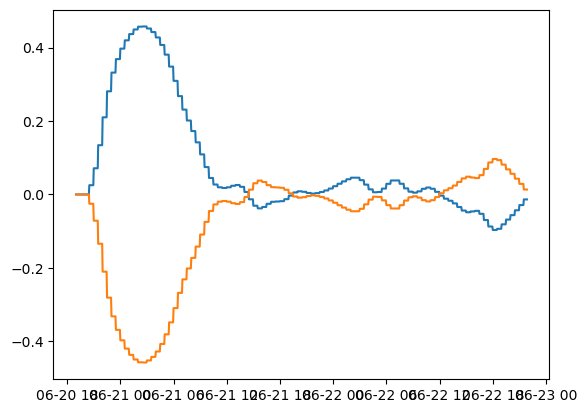

In [50]:
plt.plot(wavetrend3d(forex_data["Close"][:1000], 6, "30T", True))
plt.plot(wavetrend3d(forex_data["Close"][:1000], 6, "30T", False))

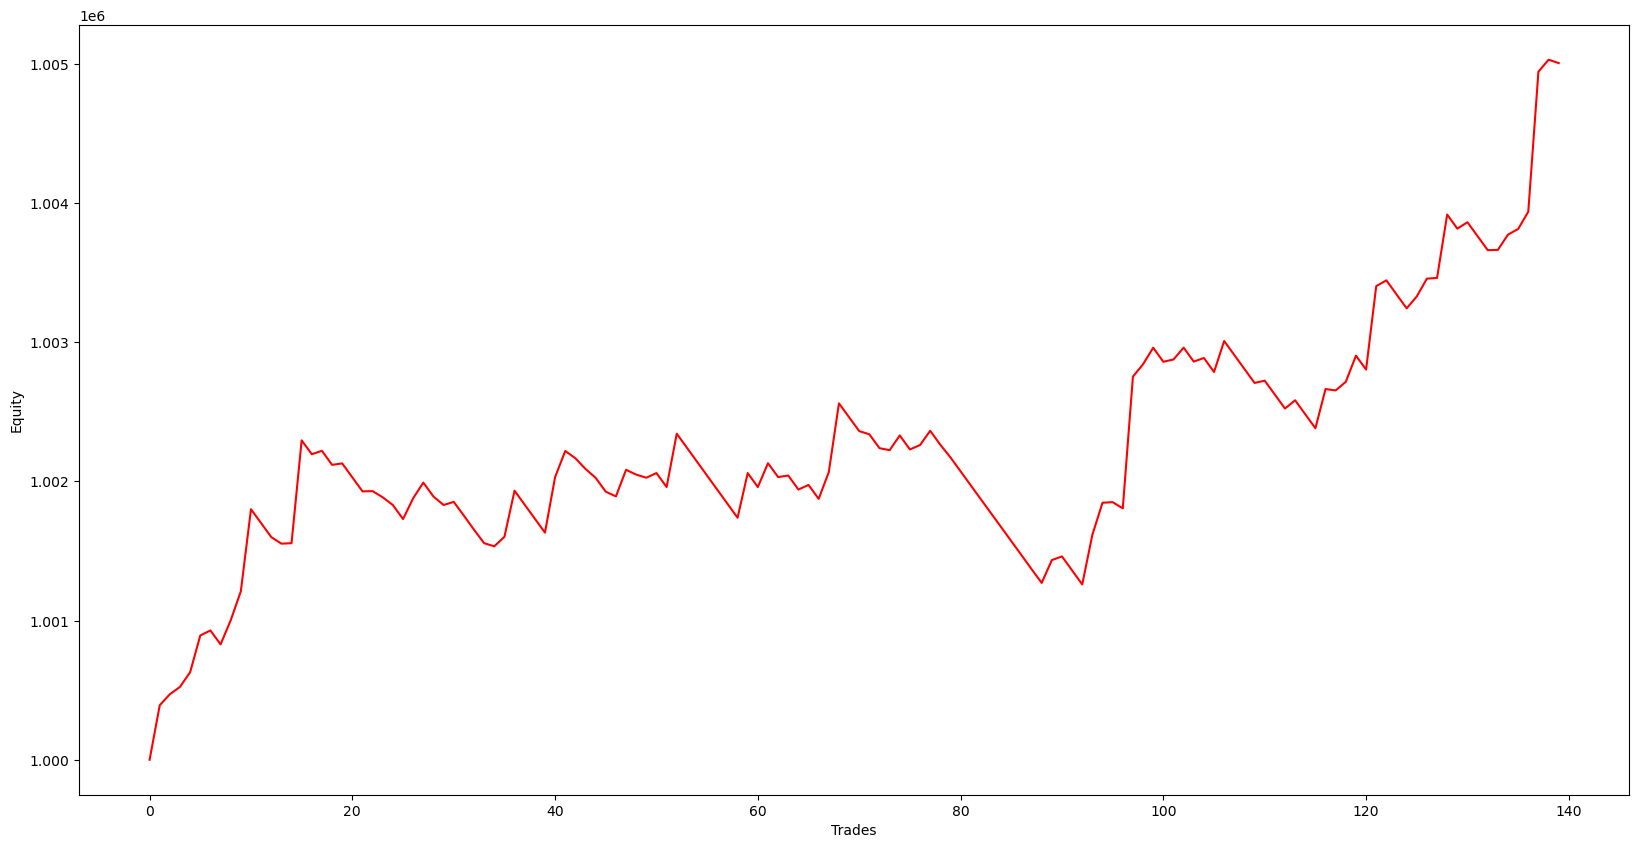

In [23]:
df = pd.read_csv('./results_lists/list.csv')

plt.figure(figsize=(20, 10))
plt.plot(df['Equity'], color='red') 
plt.xlabel('Trades')  
plt.ylabel('Equity') 
plt.show()

In [36]:
# Hier wird eine Methode geschrieben, die eine Liste von Pairs nimmt und diese dann einzelnt in den Backtest auführt
# Dabei wird jedes ergebnis (Also alle metrics gespeichert und falls gewollt auch alle plots)
# Dann wird noch eine Map erstellt mit den besten Ergebnissen und den Average ergebnissen und den schlechtesten

